# Experiment 032

In this experiment, we will train end-to-end with the board encoder and renderer architectures discovered during the autoencoder experiments.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


import models
from models import TetrisModel, TetrisDiscriminator, GameganAutoencoder
import metrics
from recording import FileBasedDatabaseWithEvents
from engines import EVENT_NAMES

In [2]:
NUM_CELL_TYPES = 8
NUM_EVENT_TYPES = 5

class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self._db = FileBasedDatabaseWithEvents(path)

    def __len__(self):
        return len(self._db)

    def __getitem__(self, idx):
        boards, events = self._db[idx]
        b = self._transform_board(boards[-2]) # Ignore all boards except the last two
        e = self._transform_event(events[-1])
        x = (b, e)
        y = self._transform_board(boards[-1])
        return x, y
    
    def _transform_board(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, NUM_CELL_TYPES) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board
    
    def _transform_event(self, event):
        event = torch.tensor(event, dtype=torch.long)
        event = F.one_hot(event, NUM_EVENT_TYPES) # One-hot encode the event
        event = event.type(torch.float) # Convert to floating-point
        return event

In [3]:
# Put datasets in memory for faster training
train_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "train")))
test_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "test")))
batch_size = 12
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

(b, e), y = next(iter(train_dataloader))
print(f"x: shape {b.shape}, dtype {b.dtype}")
print(f"e: shape {e.shape}, dtype {e.dtype}")
print(f"y: shape {y.shape}, dtype {y.dtype}")

x: shape torch.Size([12, 8, 22, 10]), dtype torch.float32
e: shape torch.Size([12, 5]), dtype torch.float32
y: shape torch.Size([12, 8, 22, 10]), dtype torch.float32


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {device}")

Using device cuda


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
def compute_metric_by_event(metric_cls, dataloader):
    metrics = [metric_cls() for _ in range(NUM_EVENT_TYPES)]

    with torch.no_grad():        
        for ((b, e), y) in dataloader:
            b = b.to(device)
            e = e.to(device)
            y = y.to(device)

            batch_size = b.size(0)

            y_fake = gen(b, e)
            
            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)

            for idx in range(batch_size):
                class_e = classes_e[idx]
                metric = metrics[class_e]
                metric.update_state(classes_x=classes_b[idx:idx+1], classes_y_pred=classes_y_fake[idx:idx+1], classes_y=classes_y[idx:idx+1])

    return [metric.result() for metric in metrics]

In [7]:
import itertools

from engines import EventTypes

def find_interesting_examples(dataset, num=3):
    num_spawns = num
    
    def inner():
        num_spawns_left = num_spawns

        for (b, e), y in dataset:
            # Check for block spawn
            if (e.argmax(0).item() == EventTypes.DROP) & (b.argmax(0)[0] == 0).all() & (y.argmax(0)[0] > 0).any():
                if num_spawns_left > 0:
                    num_spawns_left -= 1
                    yield (b, e), y
                else:
                    continue
            
    return list(itertools.islice(inner(), num))
from tetris import CELL_COLORS

def render_board(board):
    height, width = board.shape
    img = np.zeros((3, height, width))
    for row in range(height):
        for col in range(width):
            img[:, row, col] = CELL_COLORS[board[row, col]]
    img /= 255.0
    return img
def render_prediction(b, e, pred, y):
    """Renders an example and prediction into a single-image array.
    
    Inputs:
        b: Tensor of shape (height, width), the initial board state.
        e: Tensor of shape (1,), the event type.
        pred: Tensor of shape (height, width), the model prediction.
        y: Tensor of shape (height, width), the next board state.
    """
    assert len(b.shape) == 2, f"Expected tensors of shape (width, height) but got {b.shape}"
    assert b.shape == pred.shape, f"Shapes do not match: {b.shape} != {pred.shape}"
    assert b.shape == y.shape, f"Shapes do not match: {b.shape} != {y.shape}"
    assert len(e.shape) == 0, f"Expected e of shape () but got {e.shape}"
    height, width = b.shape
    with torch.no_grad():
        b = render_board(b)
        pred = render_board(pred)
        y = render_board(y)
        separator = np.ones((3, height, 1))
        return np.concatenate((b, separator, pred, separator, y), axis=-1)
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc):
    gen.train()
    disc.train()

    size = len(dataloader.dataset)
    for batch, ((b, e), y) in enumerate(dataloader):
        b = b.to(device)
        e = e.to(device)
        y = y.to(device)

        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        batch_size = b.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(b, e, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate fake image batch with generator
        y_fake = gen(b, e)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(b, e, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        ##############################################
        # (2) Update generator: minimize -log(D(G(z)))
        ##############################################
        gen.zero_grad()
        # Since we just updated the discriminator, perform another forward pass of the all-fake batch through it
        output = torch.flatten(disc(b, e, y_fake))
        # Calculate the generator's loss based on this output
        # We use real labels because the generator wants to fool the discriminator
        err_gen = loss_fn(output, real_labels)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 30 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}, G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, disc, loss_fn, tb_writer, epoch):
    gen.eval()
    disc.eval()

    loss_disc = 0.0
    loss_gen = 0.0
    disc_accuracy = 0.0
    cell_accuracy = metrics.CellAccuracy()
    board_accuracy = metrics.BoardAccuracy()
    spawn_recall = metrics.SpawnRecall()
    scores_real = np.zeros(len(dataloader.dataset))
    scores_fake = np.zeros(len(dataloader.dataset))

    num_batches = len(dataloader)
    with torch.no_grad():        
        for batch, ((b, e), y) in enumerate(dataloader):
            b = b.to(device)
            e = e.to(device)
            y = y.to(device)

            batch_size = b.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            output_real = disc(b, e, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            y_fake = gen(b, e)
            output_fake = disc(b, e, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()
            loss_gen += loss_fn(output_fake, real_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy.update_state(classes_y_fake, classes_y)
            board_accuracy.update_state(classes_y_fake, classes_y)

            spawn_recall.update_state(classes_b, classes_y_fake, classes_y)

            start_index = dataloader.batch_size * batch
            end_index = start_index + batch_size
            scores_real[start_index:end_index] = torch.sigmoid(output_real).cpu().numpy()
            scores_fake[start_index:end_index] = torch.sigmoid(output_fake).cpu().numpy()

    loss_disc /= num_batches
    loss_gen /= num_batches
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, G loss: {loss_gen:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}%, cell accuracy: {(cell_accuracy.result()):>0.1%}, board accuracy: {(board_accuracy.result()):>0.1%} \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall.result(), epoch)

    tb_writer.add_histogram(f"Discriminator scores/{split_name}/real", scores_real, epoch)
    tb_writer.add_histogram(f"Discriminator scores/{split_name}/fake", scores_fake, epoch)


pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
def train(run_name, gen_factory, disc_factory, epochs):

    learning_rate = 1e-4

    gen = gen_factory()
    disc = disc_factory()

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)
    optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_032")
    log_subdir = os.path.join(log_dir, run_name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
            test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch)
            test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch)
            gen_zero_grads = 0
            for name, weight in gen.named_parameters():
                tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
                    gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
            disc_zero_grads = 0
            for name, weight in disc.named_parameters():
                tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)
                    disc_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Discriminator zero gradients", disc_zero_grads, epoch)
    finally:
        tb_writer.close()
        
    print("Done!")
    return gen

In [9]:
NUM_RANDOM_INPUTS = 4


from models import Conv2dLeakyReLU, ConvTranspose2dLeakyReLU, LinearLeakyReLU


class GameganGenerator(nn.Module):
    def __init__(self, leak=0.0):
        super().__init__()

        self.leak = leak

        self.board_encoder = models.GameganBoardEncoder()

        self.event_encoder = nn.Sequential(
            LinearLeakyReLU(NUM_EVENT_TYPES + NUM_RANDOM_INPUTS, 32, negative_slope=leak),
            LinearLeakyReLU(32, 32, negative_slope=leak),
            LinearLeakyReLU(32, 32, negative_slope=leak),
        )

        self.dynamics = nn.Sequential(
            LinearLeakyReLU(256 + 32, 256, negative_slope=leak),
            LinearLeakyReLU(256, 256, negative_slope=leak),
            LinearLeakyReLU(256, 256, negative_slope=leak),
        )

        self.renderer = models.GameganRenderer()

    def forward(self, b, e):
        batch_size, cell_channels, height, width = b.shape

        # Encode board state
        s = self.board_encoder(b)

        # Generate random inputs
        z = torch.rand(batch_size, NUM_RANDOM_INPUTS, device=device)

        # Encode events and random inputs
        v = self.event_encoder(torch.cat((e, z), dim=1))

        # Combine encodings
        h = torch.cat((s, v), dim=1)

        # Apply game dynamics
        h = self.dynamics(h)

        # Render new board
        y = self.renderer(h)
        return y


print(f"Parameters: {count_parameters(GameganGenerator())}")

Parameters: 590280


In [10]:
class GameganDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            Conv2dLeakyReLU(2 * NUM_CELL_TYPES + NUM_EVENT_TYPES, 32, kernel_size=3),
            Conv2dLeakyReLU(32, 32, kernel_size=3),
            Conv2dLeakyReLU(32, 32, kernel_size=3),
            Conv2dLeakyReLU(32, 32, kernel_size=3),
            Conv2dLeakyReLU(32, 32, kernel_size=2),
            nn.Flatten(),
            LinearLeakyReLU(416, 32),
            nn.Linear(32, 1),
            nn.Flatten(start_dim=0),
        )

    def forward(self, b, e, y):
        batch_size, cell_channels, height, width = b.shape

        # Upscale events to board size
        e = e[:, :, None, None].repeat(1, 1, height, width)

        # Combine cells, events and random inputs
        x = torch.cat((b, e, y), dim=1)

        logits = self.body(x)
        return logits

print(f"Parameters: {count_parameters(GameganDiscriminator())}")

Parameters: 51329


In [11]:
gen = train(
    run_name="run",
    gen_factory=lambda: GameganGenerator(leak=0.2).to(device),
    disc_factory=lambda: GameganDiscriminator().to(device),
    epochs=1500
)

Epoch 0
-------------------------------
[12/8000] D loss: 1.3912, G loss: 0.6931
[372/8000] D loss: 1.1571, G loss: 0.8569
[732/8000] D loss: 0.3477, G loss: 2.0778
[1092/8000] D loss: 0.1320, G loss: 3.6649
[1452/8000] D loss: 0.0104, G loss: 5.1482
[1812/8000] D loss: 0.0097, G loss: 6.2714
[2172/8000] D loss: 0.0284, G loss: 6.2228
[2532/8000] D loss: 0.0260, G loss: 5.9038
[2892/8000] D loss: 0.0317, G loss: 6.9179
[3252/8000] D loss: 0.0377, G loss: 5.4120
[3612/8000] D loss: 0.4119, G loss: 4.4205
[3972/8000] D loss: 0.2719, G loss: 3.7956
[4332/8000] D loss: 0.1193, G loss: 4.2025
[4692/8000] D loss: 0.1362, G loss: 4.6052
[5052/8000] D loss: 0.0677, G loss: 4.4284
[5412/8000] D loss: 1.0980, G loss: 1.6414
[5772/8000] D loss: 0.5068, G loss: 3.2328
[6132/8000] D loss: 0.1739, G loss: 5.2081
[6492/8000] D loss: 0.1751, G loss: 4.2970
[6852/8000] D loss: 0.2537, G loss: 2.9841
[7212/8000] D loss: 0.1217, G loss: 4.4082
[7572/8000] D loss: 0.2621, G loss: 5.7745
[7932/8000] D loss

: 

: 

In [ ]:
cell_accuracies_train = compute_metric_by_event(metrics.CellAccuracy, train_dataloader)
cell_accuracies_test = compute_metric_by_event(metrics.CellAccuracy, test_dataloader)
board_accuracies_train = compute_metric_by_event(metrics.BoardAccuracy, train_dataloader)
board_accuracies_test = compute_metric_by_event(metrics.BoardAccuracy, test_dataloader)

for event_type in range(NUM_EVENT_TYPES):
    print(f"Stats for event type '{EVENT_NAMES[event_type]}':")
    print(f"  Cell accuracy (train): {cell_accuracies_train[event_type]:.2%}")
    print(f"  Cell accuracy (test): {cell_accuracies_test[event_type]:.2%}")
    print(f"  Board accuracy (train): {board_accuracies_train[event_type]:.2%}")
    print(f"  Board accuracy (test): {board_accuracies_test[event_type]:.2%}")
    print()

Stats for event type 'Drop':
  Cell accuracy (train): 93.03%
  Cell accuracy (test): 92.84%
  Board accuracy (train): 1.93%
  Board accuracy (test): 1.46%

Stats for event type 'Left':
  Cell accuracy (train): 92.22%
  Cell accuracy (test): 91.78%
  Board accuracy (train): 0.41%
  Board accuracy (test): 0.00%

Stats for event type 'Right':
  Cell accuracy (train): 92.34%
  Cell accuracy (test): 92.13%
  Board accuracy (train): 0.63%
  Board accuracy (test): 0.23%

Stats for event type 'Rotate':
  Cell accuracy (train): 91.53%
  Cell accuracy (test): 91.80%
  Board accuracy (train): 0.00%
  Board accuracy (test): 0.00%

Stats for event type 'Insta-drop':
  Cell accuracy (train): 92.59%
  Cell accuracy (test): 92.34%
  Board accuracy (train): 0.60%
  Board accuracy (test): 0.47%



In [ ]:
def show_prediction(example):
    (b, e), y = example
    pred = gen(b.to(device).unsqueeze(0), e.to(device).unsqueeze(0)).squeeze(0).cpu()
    b, e, y, pred = b.argmax(0), e.argmax(0), y.argmax(0), pred.argmax(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle(f"Prediction vs reality\nEvent = {EVENT_NAMES[e]}")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Predicted")
    axs[2].set_title("Reality")

    num_mistakes = (y != pred).type(torch.int).sum().item()
    print(f"Mistakes: {num_mistakes}")
    axs[0].imshow(render_board(b).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[1].imshow(render_board(pred).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[2].imshow(render_board(y).transpose((1, 2, 0)), vmin=0, vmax=1)

    plt.show()

Showing prediction for training example 4396
Mistakes: 15


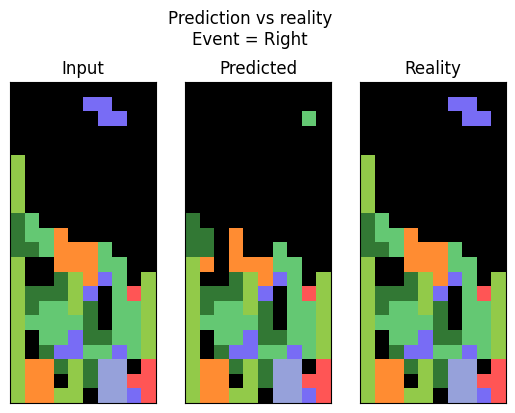

In [ ]:
# Show a random training prediction vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

In [ ]:
# torch.save(gen.state_dict(), "gamegan_emulator.pth")

# Conclusion

The generator learns a lot more slowly when trained end-to-end with the discriminator, and after 731 epochs (thanks to Windows Update for restarting my PC during a training run!!) we only get 17% training and 7% test board accuracy.

Therefore, we should keep using fine-tuning for now. To test whether it is the GAN training itself causing the poor result in end-to-end training, we can try training without the discriminator and just computing the MSE loss between the real and predicted next frame.